<a href="https://colab.research.google.com/github/Rktim/Fruit_Classifiaction/blob/b1/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip MY_data.zip

Archive:  MY_data.zip
   creating: MY_data/
   creating: MY_data/predict/
  inflating: MY_data/predict/0.jpeg  
  inflating: MY_data/predict/1.jpeg  
  inflating: MY_data/predict/2.jpeg  
  inflating: MY_data/predict/3.jpeg  
  inflating: MY_data/predict/4.jpeg  
  inflating: MY_data/predict/img_121.jpeg  
  inflating: MY_data/predict/img_141.jpeg  
  inflating: MY_data/predict/img_171.jpeg  
  inflating: MY_data/predict/img_191.jpeg  
  inflating: MY_data/predict/img_301.jpeg  
  inflating: MY_data/predict/img_341.jpeg  
  inflating: MY_data/predict/img_401.jpeg  
  inflating: MY_data/predict/img_411.jpeg  
  inflating: MY_data/predict/img_421.jpeg  
   creating: MY_data/test/
   creating: MY_data/test/apple/
  inflating: MY_data/test/apple/img_1001.jpeg  
  inflating: MY_data/test/apple/img_101.jpeg  
  inflating: MY_data/test/apple/img_1011.jpeg  
  inflating: MY_data/test/apple/img_1031.jpeg  
  inflating: MY_data/test/apple/img_1041.jpeg  
  inflating: MY_data/test/apple/img_1051.

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [ ]:
my_data_path = os.path.join( "MY_data")
os.listdir(my_data_path)

['test', 'predict', 'train']

In [ ]:
train_path = os.path.join(my_data_path, "train")
test_path = os.path.join(my_data_path, "test")
predict_path = os.path.join(my_data_path, "predict")

train_classes = os.listdir(train_path)
test_classes = os.listdir(test_path)

print(f"train set:{train_classes} \n test set{ test_classes}")


train set:['mango', 'Banana', 'Apple'] 
 test set['banana', 'mango', 'apple']


In [ ]:
image_paths = []
labels = []

for class_name in train_classes:
    class_dir = os.path.join(train_path, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image_paths.append(image_path)
        labels.append(class_name)

train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")
print(f"Number of test images: {len(os.listdir(test_path))}")


Number of training images: 552
Number of validation images: 139
Number of test images: 3


In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 64
BUFFER_SIZE = tf.data.AUTOTUNE

X_train = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

X_valid = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

X_train = X_train.map(preprocess).cache().prefetch(buffer_size=BUFFER_SIZE)
X_valid = X_valid.map(preprocess).cache().prefetch(buffer_size=BUFFER_SIZE)


Found 691 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
model = keras.Sequential([
    vgg,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,561,795 (105.14 MB)

 Trainable params: 12,847,107 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(X_train,
    validation_data=X_valid,
    epochs=10,
    verbose=1
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 585s 55s/step - accuracy: 0.4193 - loss: 8.2921 - val_accuracy: 0.6800 - val_loss: 0.9613
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 581s 50s/step - accuracy: 0.7099 - loss: 1.1845 - val_accuracy: 0.5867 - val_loss: 2.1015
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 531s 50s/step - accuracy: 0.7682 - loss: 0.8271 - val_accuracy: 0.7867 - val_loss: 0.5481
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 573s 54s/step - accuracy: 0.9239 - loss: 0.2009 - val_accuracy: 0.8033 - val_loss: 0.5417
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 585s 50s/step - accuracy: 0.9521 - loss: 0.1555 - val_accuracy: 0.8600 - val_loss: 0.4152
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 572s 54s/step - accuracy: 0.9551 - loss: 0.1119 - val_accuracy: 0.8700 - val_loss: 0.3941
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 531s 50s/step - accuracy: 0.9721 - loss: 0.0887 - val_accuracy: 0.8467 - val_loss: 0.4096
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 562s 50s/step - accuracy: 0.9859 - loss: 0.0598 - val_accuracy: 0.

In [ ]:
model.save('vgg_mod.keras')

In [ ]:
vgg_model = tf.keras.models.load_model('vgg_mod.keras')

In [ ]:
loss, accuracy = vgg_model.evaluate(X_valid)
print(f"Test Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 183s 33s/step - accuracy: 0.8796 - loss: 0.4130
Test Accuracy: 0.8667


5/5 ━━━━━━━━━━━━━━━━━━━━ 166s 33s/step


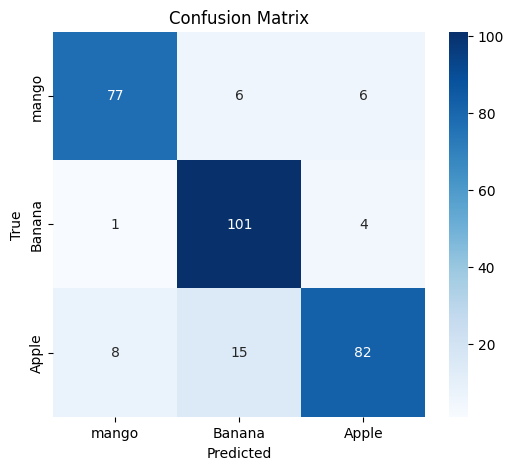

In [ ]:
predictions = vgg_model.predict(X_valid)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y.numpy() for _, y in X_valid])
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_path), yticklabels=os.listdir(train_path))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=os.listdir(train_path)))

Classification Report:
              precision    recall  f1-score   support

       mango       0.90      0.87      0.88        89
      Banana       0.83      0.95      0.89       106
       Apple       0.89      0.78      0.83       105

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300



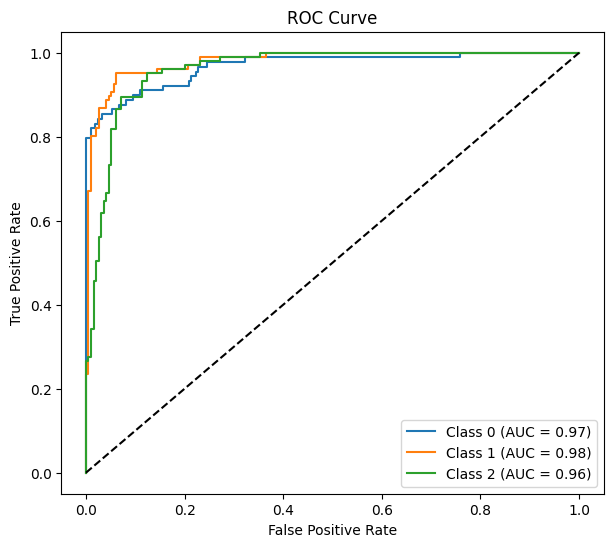

In [ ]:
fpr, tpr, roc_auc = {}, {}, {}
y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=3)
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

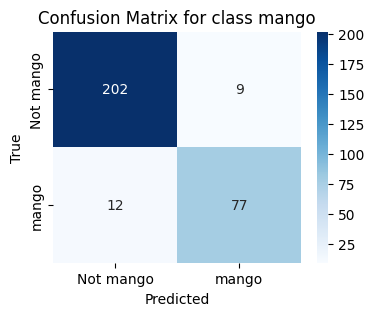

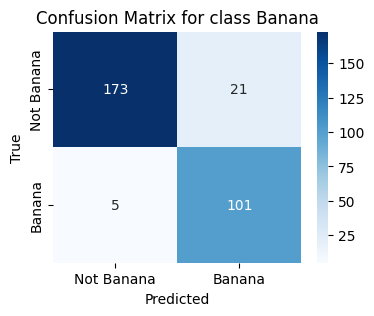

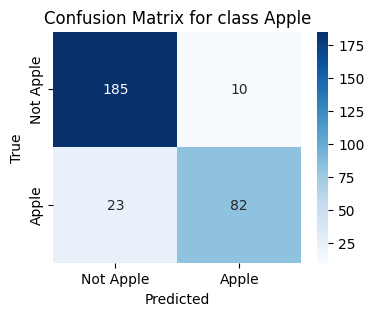

In [ ]:
for class_idx in range(len(train_classes)):
  class_cm = confusion_matrix(y_true == class_idx, y_pred == class_idx)
  plt.figure(figsize=(4, 3))
  sns.heatmap(class_cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Not ' + train_classes[class_idx], train_classes[class_idx]],
              yticklabels=['Not ' + train_classes[class_idx], train_classes[class_idx]])
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(f"Confusion Matrix for class {train_classes[class_idx]}")
  plt.show()
